In [112]:
from mnist import *
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import matplotlib
import warnings

warnings.simplefilter("ignore")

training_set_path = "D:\\Projects\\ml-experiments\\datasets\\mnist\\train-images-idx3-ubyte.gz"
labels_path = "D:\\Projects\\ml-experiments\\datasets\\mnist\\train-labels-idx1-ubyte.gz"

f_train = gzip.open(training_set_path)
f_labels = gzip.open(labels_path)

training_set = parse_idx(f_train)
labels = parse_idx(f_labels)

**Some utility functions to reuse throughout this experiment:**

In [113]:
def get_index_of_random_true(binary_labels):
    indexes_of_trues = np.where(binary_labels == True)[0]
    return indexes_of_trues[np.random.randint(0, len(indexes_of_trues) - 1)]

def get_index_of_random_false(binary_labels):
    indexes_of_falses = np.where(binary_labels == False)[0]
    return indexes_of_falses[np.random.randint(0, len(indexes_of_falses) - 1)]

def get_thresholds_for(precisions, recalls, thresholds, precision_at_least, recall_at_least):
    indexes_precisions = np.where(precisions > precision_at_least)[0]
    indexes_recalls = np.where(recalls > recall_at_least)[0]
    intersection_indexes = np.intersect1d(indexes_precisions, indexes_recalls)

    return thresholds[intersection_indexes]

def show_digit(digit):
    if digit.shape != (28, 28):
        digit = digit.reshape((28, 28))
    plt.imshow(digit, cmap=matplotlib.cm.binary, interpolation="nearest")
    plt.show()

**Training set needs to be reshaped from 3D (60000,28,28) to 2D (60000, 784) for the classifier to be able to use in training phase**

In [114]:
training_set_tr = training_set.reshape((60000, 784))

**Transform the labels to an array of binary labels (5 or not 5)**

In [115]:
five_binary_labels = (labels == 5)
sgd_classifier = SGDClassifier(random_state=77)
sgd_classifier.fit(training_set_tr, five_binary_labels)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=77, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

**Pick a five**

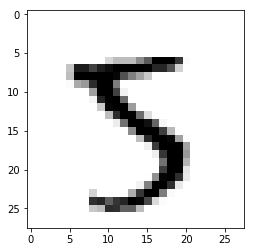

In [116]:
index_of_five = get_index_of_random_true(five_binary_labels)
some_digit = training_set_tr[index_of_five, ]
show_digit(some_digit)

In [117]:
print("some_digit is a 5:", sgd_classifier.predict([some_digit]))

some_digit is a 5: [ True]


**Pick a not five**

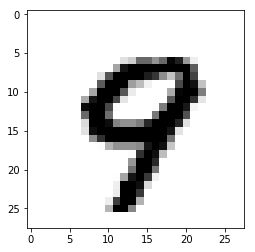

In [118]:
index_of_not_five = get_index_of_random_false(five_binary_labels)
some_digit = training_set_tr[index_of_not_five, ]
show_digit(some_digit)

In [119]:
print("some_digit is a 5:", sgd_classifier.predict([some_digit]))

some_digit is a 5: [False]


**Evaluate the current SGD classifier**

In [120]:
y_train_pred = cross_val_predict(sgd_classifier, training_set_tr, five_binary_labels, cv=3)
cm = confusion_matrix(five_binary_labels, y_train_pred)
print("Confusion Matrix for random_state = 77:")
print(cm)

Confusion Matrix for random_state = 77:
[[54168   411]
 [ 1762  3659]]


**Each row represents an actual class (being a binary classifier only two classes: 0 and 1 top-down) and each column represents a predicted class (0 and 1 left-right). That is 54168 true negatives, 411 false positives, 1762 false negatives and 3659 true positives**

**Precision: $\frac{TP}{TP+FP}$**

In [121]:
print(f"Precision for random_state=77: {precision_score(five_binary_labels, y_train_pred)}")

Precision for random_state=77: 0.899017199017199


**Recall (Sensitivity): $\frac{TP}{TP+FN}$**

In [122]:
print(f"Sensitivity for random_state=77: {recall_score(five_binary_labels, y_train_pred)}")

Sensitivity for random_state=77: 0.6749677181331858


**Precision and Sensitivity are 1 for an IDEAL classifier. That is when both FP and FN are 0 (in other words no mistakes). Let's try with a lower random_state:**

In [123]:
sgd_classifier = SGDClassifier(random_state=42)

y_train_pred = cross_val_predict(sgd_classifier, training_set_tr, five_binary_labels, cv=3)
cm = confusion_matrix(five_binary_labels, y_train_pred)

print("Confusion Matrix for random_state=42:")
print(cm)
print(f"Precision for random_state=42: {precision_score(five_binary_labels, y_train_pred)}")
print(f"Sensitivity for random_state=42: {recall_score(five_binary_labels, y_train_pred)}")

Confusion Matrix for random_state=42:
[[52992  1587]
 [ 1074  4347]]
Precision for random_state=42: 0.7325581395348837
Sensitivity for random_state=42: 0.8018815716657444


**Precision-Recall Trade off:**

**Increasing the threshold increases precision and decreases recall. Conversely, decreasing threshold increases recall and decreases precision**

**The random_state parameter of the classifier corresponds to the threshold. A binary classifier (such as this SGDClassifier) implements a decision function that outputs a score. If the score is greater than the threshold, the output of a simple prediction will be the positive class otherwise negative**

In [124]:
sgd_classifier = SGDClassifier(random_state=77)
sgd_classifier.fit(training_set_tr, five_binary_labels)

index_of_five = get_index_of_random_true(five_binary_labels)
some_digit = training_set_tr[index_of_five, ]

score = sgd_classifier.decision_function([some_digit])
threshold = 0

print(score > threshold)

[ True]


In [125]:
threshold = 300000
print(score > threshold)

[False]


In [126]:
sgd_classifier = SGDClassifier(random_state=77)

**Get the scores of all instances in the training set using K-fold predictions**

In [127]:
scores = cross_val_predict(sgd_classifier, training_set_tr, five_binary_labels, cv=3, method="decision_function")

**Now compute the Precision-Recall curves for each possible thresholds**

In [128]:
precisions, recalls, thresholds = precision_recall_curve(five_binary_labels, scores)

**Get list of thresholds that would result in a precision of at least 88% and recall of at least 70%. Note ndarrays of precision and recall (dimension 1) are one element larger than thresholds so we select all but last element**

In [130]:
thresholds_for_precision_and_recall = get_thresholds_for(precisions[:-1], recalls[:-1], thresholds, 0.88, 0.70)
print(f"Thresholds for Precision at least 0.88 and Recall at least 0.7 are:{thresholds_for_precision_and_recall}")

Thresholds for Precision at least 0.88 and Recall at least 0.7 are:[-15023.28424725 -14976.36859095 -14947.85029725 -14733.83007086
 -14627.36187948 -14590.34676995 -14552.7316343  -14548.95052097
 -14526.06483497 -14518.00509337 -14466.15635848 -14425.36781658
 -14413.02176577 -14355.7080478  -14236.00595972 -14229.34994907
 -14154.06525354 -14144.12263626 -14090.78135661 -14061.28640324
 -14048.94803339 -14021.88322212 -14016.15411966 -13999.43761858
 -13983.21863242 -13922.08173057 -13854.26276697 -13823.62653751
 -13802.52121602 -13785.51388696 -13695.16818697 -13693.07561611
 -13668.49069846]


**We get 33 possible threshold values for which the precision would be at least 88% and recall at least 70%. Test one of them**

In [131]:
test_threshold = thresholds_for_precision_and_recall[np.random.randint(0, len(thresholds_for_precision_and_recall) - 1)]
predictions = scores > test_threshold

print(f"Precision:{precision_score(five_binary_labels, predictions)}")
print(f"Sensitivity: {recall_score(five_binary_labels, predictions)}")

Precision:0.8814385150812065
Sensitivity: 0.7007932115845785
